In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# Queries
## Parte I


    SELECT gaia.source_id, gaia.hip
Indica que valores va a obtener del catálogo como *gaia.source_id*,* gaia.hip* y *hip."B-V"*.

    gaia.phot_g_mean_mag+5*log10(gaia.parallax)-10 as g_mag_abs_gaia,
    gaia.phot_g_mean_mag+5*log10(hip.plx)-10 as g_mag_abs_hip,
    hip."B-V"
Se pude guardar valores que dependan de otros del catálogo así se obtiene la magnitud G de Gaia e Hipparcos.
    
    FROM "I/337/tgas" AS gaia
    INNER JOIN "I/311/hip2" as hip
Dice donde buscar el catálogo y se le asigna un alias.
    
    ON gaia.hip = hip.HIP
Realiza un match entre los dos catálogos.
    
    WHERE gaia.parallax/gaia.parallax_error >= 5 AND
    hip.Plx/hip.e_Plx >= 5 AND
    hip."e_B-V" > 0.0 and hip."e_B-V" <= 0.05 AND
    (2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05
Además se pueden imponer ciertas restricciones a los valores, como exijir S/N > 5 en paralaje y otas más para el error en el color y en la magnitud G.



Luego se ejecuta *act4.py* que es el código provisto por el profesor para extraer los datos y para graficar.

In [2]:
import act4

tap = 'http://tapvizier.u-strasbg.fr/TAPVizieR/tap'
adql = """ SELECT gaia.source_id, gaia.hip,
gaia.phot_g_mean_mag+5*log10(gaia.parallax)-10 as g_mag_abs_gaia,
gaia.phot_g_mean_mag+5*log10(hip.plx)-10 as g_mag_abs_hip,
hip."B-V"
FROM "I/337/tgas" AS gaia
INNER JOIN "I/311/hip2" as hip
ON gaia.hip = hip.HIP
WHERE gaia.parallax/gaia.parallax_error >= 5 AND
hip.Plx/hip.e_Plx >= 5 AND
hip."e_B-V" > 0.0 and hip."e_B-V" <= 0.05 AND
(2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05 """

la_cosa = act4.query_TAP(tap,adql)

Se crean dos CMD para las magnitudes dadas por Hipparcos y por Gaia, sin embargo, los colores son iguales para los dos y fueron obtenidos por Hipparcos.

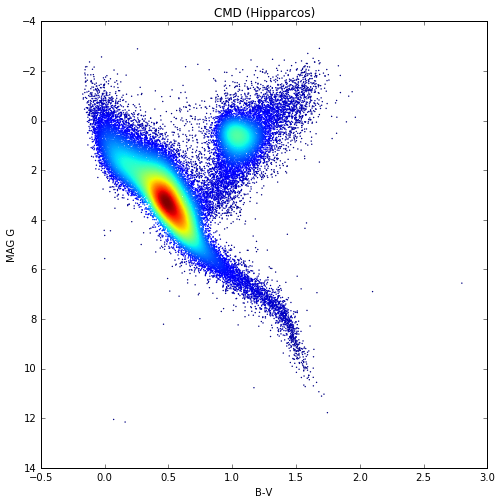

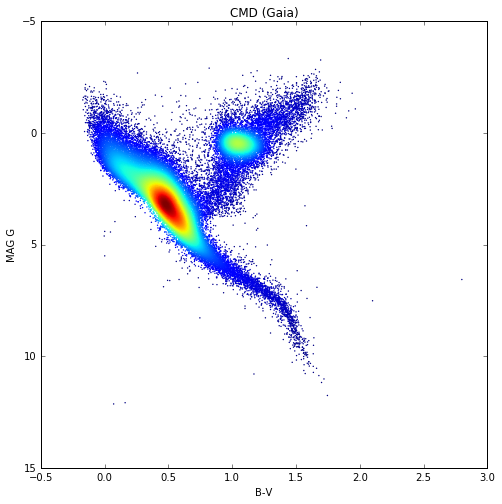

In [3]:
%matplotlib inline
act4.plot_scatter_density(la_cosa,'B-V','g_mag_abs_hip','B-V','MAG G','CMD (Hipparcos)')
act4.plot_scatter_density(la_cosa,'B-V','g_mag_abs_gaia','B-V','MAG G','CMD (Gaia)')




## Parte II

### SDSS
El SDSS es uno de los más ambiciosos e influentes estudios en la astronomía moderna, ha mapedo el universo en tres dimensiones (un tercio del cielo aproximadamente) que incluyen imágenes multicolor y espectros de más de tres millones de objetos astronómicos. Por esta misma razón es que toma relevanci ya que crea una base de datos de multiples objetos y aun hoy en día continúa el proyecto SDSS. 

Luego se procede a ejecutar el SQL imponiendo en *Context* DR8 que significa *Data Release 8*


Se bajarán los datos:

    SELECT
    G.ra, G.dec, S.mjd, S.plate, S.fiberID,
    S.z, S.zErr, S.rChi2, S.velDisp, S.velDispErr,
    G.extinction_r, G.petroMag_r, G.psfMag_r, G.psfMagErr_r,
    G.modelMag_u, G.modelMagErr_u, G.modelMag_g, G.modelMagErr_g,
    G.modelMag_r, G.modelMagErr_r, G.modelMag_i, G.modelMagErr_i,
    G.modelMag_z, G.modelMagErr_z, G.petroR50_r, G.petroR90_r,
    GSL.nii_6584_flux, GSL.nii_6584_flux_err, GSL.h_alpha_flux,
    GSL.h_alpha_flux_err, GSL.oiii_5007_flux, GSL.oiii_5007_flux_err,
    GSL.h_beta_flux, GSL.h_beta_flux_err, GSL.h_delta_flux, GSL.h_delta_flux_err,
    GSX.d4000, GSX.d4000_err, GSE.bptclass,
    GSE.lgm_tot_p50, GSE.sfr_tot_p50, G.objID, GSI.specObjID
las coordenadas RA y DEC, mjd, plate y fiberID necesarias para la parte de espectros,
el redshift y el error asociado, el error de chi cuadrado, la velocidad de dispersión y el error asociado,
el valor de la extinción, la magnitud petrosian, magnitud de PSF y el error asociado,
modelos para magnitud de las bandas u, g, r, i, z y sus respectivos errores, la magnitud petrosian en el percentil 50 y en el 90,
el flujo de NII, OIII, H$_{\beta}$, H$_{\alpha}$, H$_{\delta}$
    

    INTO mydb.SDSS FROM SpecObj S CROSS APPLY
    dbo.fGetNearestObjEQ(S.ra, S.dec, 0.06) N, Galaxy G,
    GalSpecInfo GSI, GalSpecLine GSL, GalSpecIndx GSX,
    GalSpecExtra GSE
Se descargan los valores

    
    WHERE N.objID = G.objID
    AND GSI.specObjID = S.specObjID
    AND GSL.specObjID = S.specObjID
    AND GSX.specObjID = S.specObjID
    AND GSE.specObjID = S.specObjID
    AND (G.petroMag_r > 10 AND G.petroMag_r < 18)
    AND (G.modelMag_u - G.modelMag_r) > 0
    AND (G.modelMag_u - G.modelMag_r) < 6
    AND (modelMag_u > 10 AND modelMag_u < 25)
    AND (modelMag_g > 10 AND modelMag_g < 25)
    AND (modelMag_r > 10 AND modelMag_r < 25)
    AND (modelMag_i > 10 AND modelMag_i < 25)
    AND (modelMag_z > 10 AND modelMag_z < 25)
    AND S.rChi2 < 2
    AND (S.zErr > 0 AND S.zErr < 0.01)
    AND S.z > 0.02 
Se imponen las restricciones; entre ellas acotar las magnitudes al rango 10,25 de las bandas u,g,r,i,z, 10,18 en la magnitud petrosian, 0,6 en el color ur, restriccion para chi cuadrado menos a 2, acotar el el error del redshift a 0,0.01, restringir el redshift para que sea mayor que 0.02.

In [4]:
from astropy.io.fits import getdata

data,header = getdata('./SDSS_Pedro73.fit',ext=1,header="True")

In [5]:
def filter_SN(x1array,x2array,y1array,y2array,z1array,z2array,w1array,w2array,SN):
    
    index_no_zeros1 = np.nonzero(y1array)[0]     
    aux1=[]
    
    aux1.append(x1array[index_no_zeros1])
    aux1.append(x2array[index_no_zeros1])
    aux1.append(y1array[index_no_zeros1])
    aux1.append(y2array[index_no_zeros1])
    aux1.append(z1array[index_no_zeros1])
    aux1.append(z2array[index_no_zeros1])
    aux1.append(w1array[index_no_zeros1])
    aux1.append(w2array[index_no_zeros1])
    
    aux2=[]
    index_no_zeros2 = np.nonzero(np.array(aux1[6]))[0]
    
    aux2.append(aux1[0][index_no_zeros2])
    aux2.append(aux1[1][index_no_zeros2])
    aux2.append(aux1[2][index_no_zeros2])
    aux2.append(aux1[3][index_no_zeros2])
    aux2.append(aux1[4][index_no_zeros2])
    aux2.append(aux1[5][index_no_zeros2])
    aux2.append(aux1[6][index_no_zeros2])
    aux2.append(aux1[7][index_no_zeros2])
    
    aux3=[]
    for i in range(0,len(aux2[2])):
        if (aux2[0][i]/aux2[1][i]) > SN and \
        (aux2[2][i]/aux2[3][i]) > SN and \
        (aux2[4][i]/aux2[5][i]) > SN and \
        (aux2[6][i]/aux2[7][i]) > SN :
            aux3.append([aux2[0][i],aux2[1][i],aux2[2][i],aux2[3][i],aux2[4][i],aux2[5][i],aux2[6][i],aux2[7][i]])
    
    aux3 = np.array(aux3)
    return np.array(aux3[:,0]),np.array(aux3[:,1]),np.array(aux3[:,2]),np.array(aux3[:,3]),\
np.array(aux3[:,4]),np.array(aux3[:,5]),np.array(aux3[:,6]),np.array(aux3[:,7])

In [6]:
NII = data['nii_6584_flux']
NII_err = data['nii_6584_flux_err']
OIII = data['oiii_5007_flux']
OIII_err = data['oiii_5007_flux_err']
H_alpha = data['h_alpha_flux']
H_alpha_err = data['h_alpha_flux_err']
H_beta = data['h_beta_flux']
H_beta_err = data['h_beta_flux_err']
RA = data['ra']
DEC = data['dec']

new_NII, new_NII_err, new_H_alpha, new_H_alpha_err, new_OIII, new_OIII_err, new_H_beta, new_H_beta_err = \
filter_SN(NII,NII_err,H_alpha,H_alpha_err,OIII,OIII_err,H_beta,H_beta_err,10)

Luego se crea un diagrama  Baldwin, Phillips & Terlevich o BPT Diagram que grafica en el eje x el logaritmo de la razón entre el flujo de la linea prohibida de NII (puede ser otra linea prohibida) y la linea de H$_{\alpha}$ (Balmer alpha) y en el eje y el logaritmo de la razón entre el flujo de la linea de prohibida de OIII y la linea de H$_{\beta}$ (Balmer beta). Este diagrama permite identificar a gaxias que emiten fuertemente en HII y a galaxias tipo AGN como los QSO y LINER.

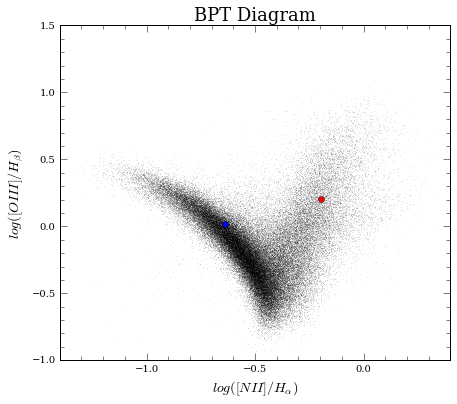

In [7]:
%matplotlib inline

from matplotlib import rcParams
minorLocator1 = AutoMinorLocator()
minorLocator2 = AutoMinorLocator()

rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(figsize=[7,6])
x = np.log10(new_NII/new_H_alpha)
y = np.log10(new_OIII/new_H_beta)
ax.plot(x,y,'.k',ms=1,alpha=.1)
ax.plot(x[4500],y[4500],'or')
ax.plot(x[13],y[13],'ob')

ax.yaxis.set_minor_locator(minorLocator1)
ax.xaxis.set_minor_locator(minorLocator2)

plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4)

ax.set_ylabel("$log([OIII]/H_{\\beta})$",fontsize=14)
ax.set_xlabel("$log([NII]/H_{\\alpha})$",fontsize=14)
ax.set_title("BPT Diagram",size = 18)

Finalmente se escojen dos galaxias, la galaxia que se representa con el punto azul es una que emite en HII y el punto rojo representa un AGN tipo LINER, luego se grafican sus espectros.

/home/pedro/anaconda2/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


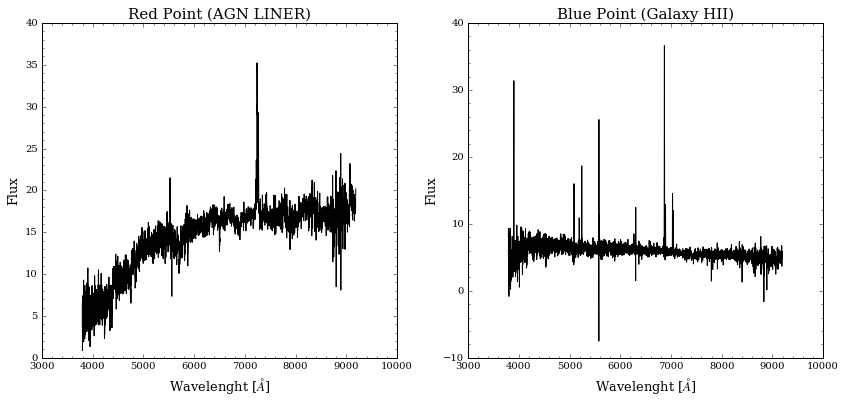

In [8]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u

minorLocator1 = AutoMinorLocator()
minorLocator2 = AutoMinorLocator()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=[14, 6])

ra = RA[np.where(OIII==new_OIII[4500])]
dec = DEC[np.where(OIII==new_OIII[4500])]

pos = coords.SkyCoord(ra*u.degree,dec*u.degree, frame='icrs')
xid = SDSS.query_region(pos, spectro=True)
sp = SDSS.get_spectra(matches=xid)

hdulist=sp[0]
c0 = hdulist[0].header['coeff0']
c1 = hdulist[0].header['coeff1']
npix = hdulist[1].header['naxis2']
wave = 10.**(c0 + c1 * np.arange(npix))
flux = hdulist[1].data['flux']

ax[0].plot(wave,flux,'-k')
ax[0].set_ylabel("Flux",fontsize=13)
ax[0].set_xlabel("Wavelenght [$\\AA$]",fontsize=13)
ax[0].set_title('Red Point (AGN LINER)',size = 15)
ax[0].yaxis.set_minor_locator(minorLocator1)
ax[0].xaxis.set_minor_locator(minorLocator2)

ra = RA[np.where(OIII==new_OIII[13])]
dec = DEC[np.where(OIII==new_OIII[13])]

pos = coords.SkyCoord(ra*u.degree,dec*u.degree, frame='icrs')
xid = SDSS.query_region(pos, spectro=True)
sp = SDSS.get_spectra(matches=xid)

hdulist=sp[0]
c0 = hdulist[0].header['coeff0']
c1 = hdulist[0].header['coeff1']
npix = hdulist[1].header['naxis2']
wave = 10.**(c0 + c1 * np.arange(npix))
flux = hdulist[1].data['flux']

minorLocator1 = AutoMinorLocator()
minorLocator2 = AutoMinorLocator()

ax[1].plot(wave,flux,'-k')
ax[1].set_ylabel("Flux",fontsize=13)
ax[1].set_xlabel("Wavelenght [$\\AA$]",fontsize=13)
ax[1].set_title('Blue Point (Galaxy HII)',size = 15)
ax[1].yaxis.set_minor_locator(minorLocator1)
ax[1].xaxis.set_minor_locator(minorLocator2)



## Parte III

Se descargan los modelos tipicos que tendrían distintos objetos astronómicos, los modelos son descargados con el módulo *astroquery.sdss* que incluyen estrellas y galaxias con sus respectivas subdivisiones. Las lineas de emisión/bsorción son señaladas con flechas rojas y estas se ubican según el HDU2 (http://classic.sdss.org/dr7/dm/flatFiles/spSpec.html#hdu2), sin embargo, no contiene lineas para las galaxias.

In [15]:
def plot(result,name,xpos):
    hdulist=result[0]
    c0 = hdulist[0].header['coeff0']
    c1 = hdulist[0].header['coeff1']
    npix = hdulist[0].header['naxis1']
    wave = 10.**(c0 + c1 * np.arange(npix))
    flux = hdulist[0].data[0,:]

    minorLocator1 = AutoMinorLocator()
    minorLocator2 = AutoMinorLocator()
    
    fig, ax = plt.subplots(figsize=[13,9])
    ax.plot(wave,flux,'-k')

    ax.yaxis.set_minor_locator(minorLocator1)
    ax.xaxis.set_minor_locator(minorLocator2)
    
    ax.set_ylabel("Flux",fontsize=13)
    ax.set_xlabel("Wavelength [$\\AA$]",fontsize=13)
    ax.set_title(name,size = 17)
    
    f = interpolate.interp1d(wave,flux,'linear',bounds_error=False,fill_value=np.nan)
    xpos = xpos
    ypos = f(xpos)
    for i in range(0,len(xpos)):
        ax.annotate(' ',
                 xy=(xpos[i],ypos[i]), xycoords='data',
                 xytext=(+10, +30), textcoords='offset points', fontsize=8,
                 arrowprops=dict(facecolor='red', shrink=0.05,width=3,headwidth=7))

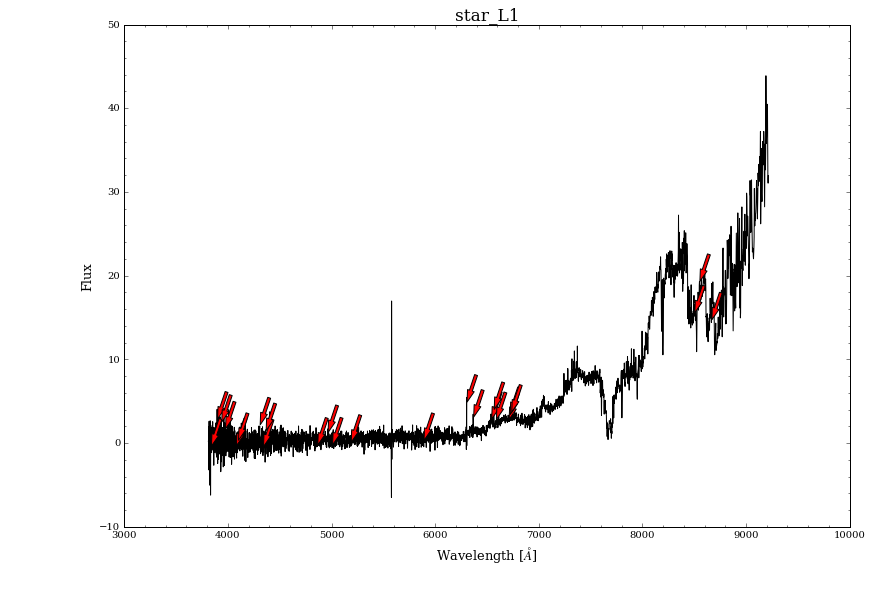

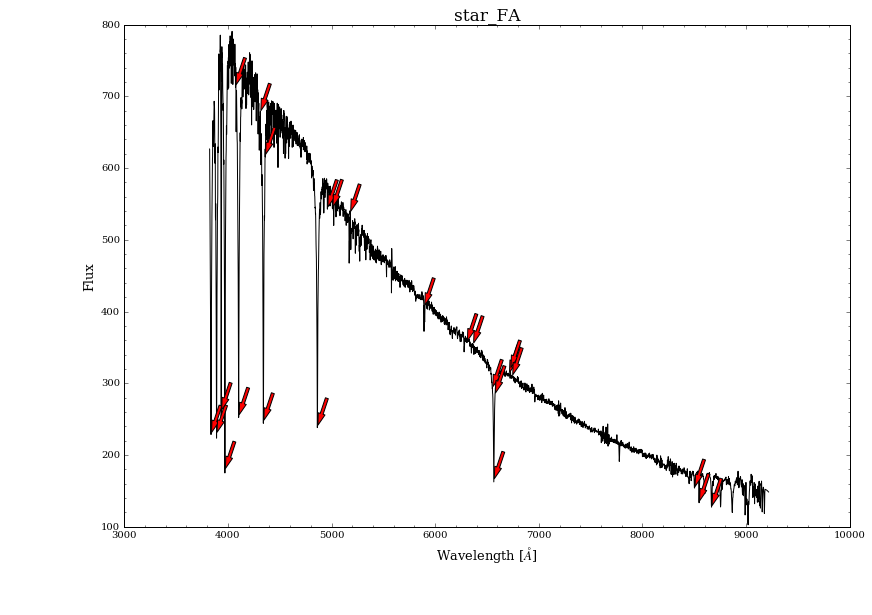

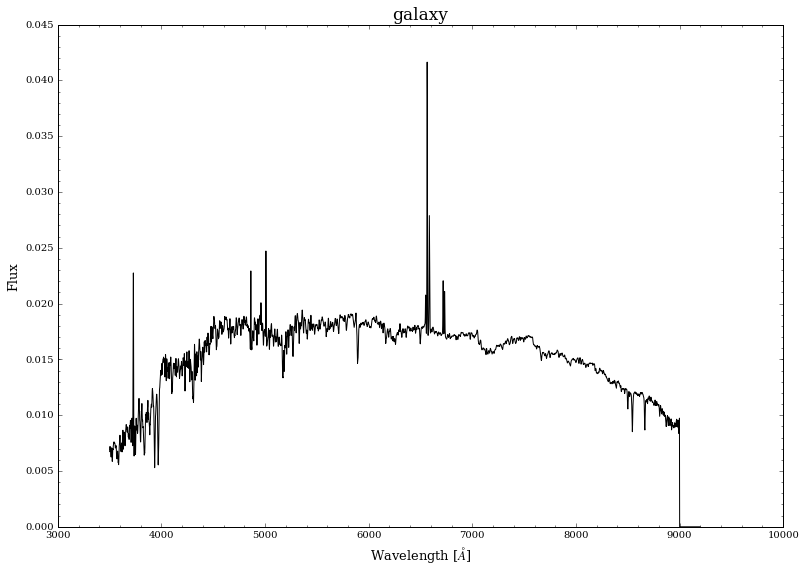

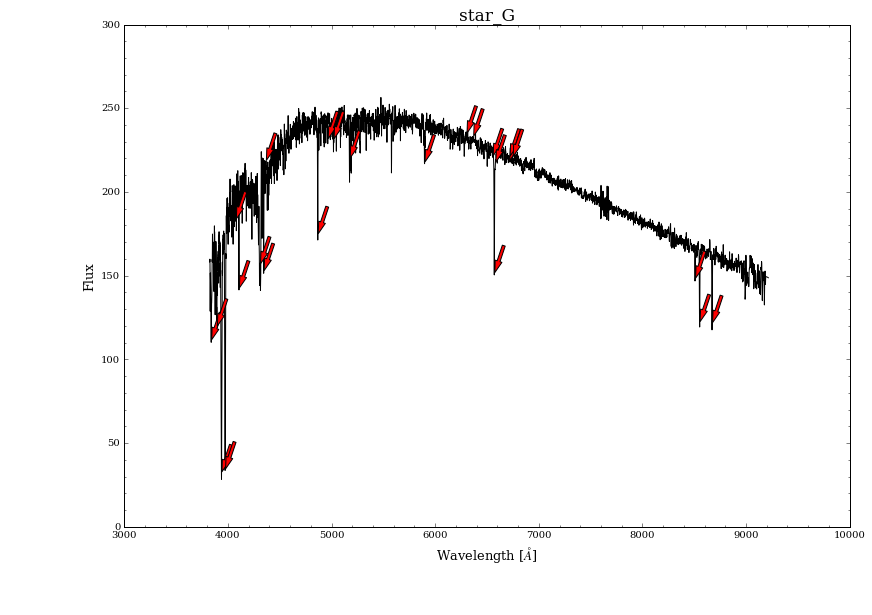

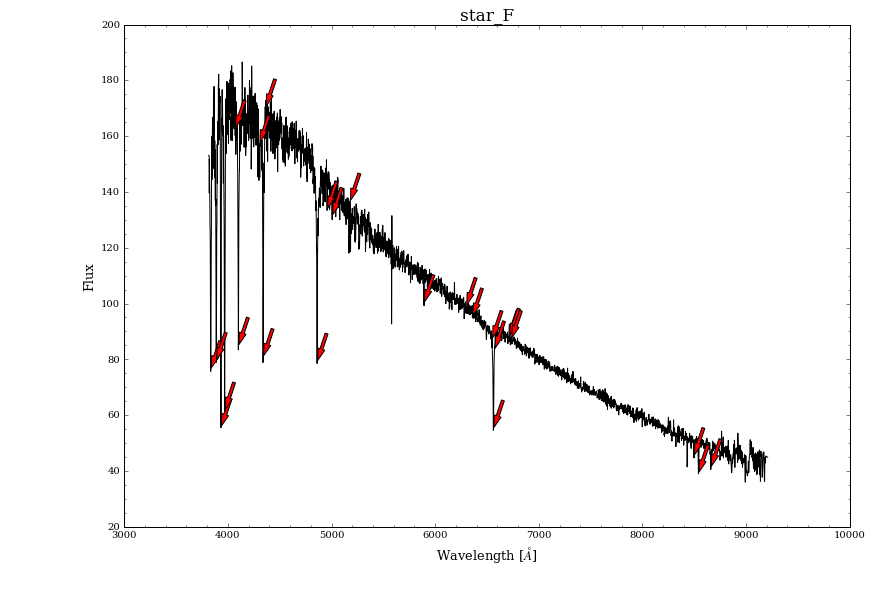

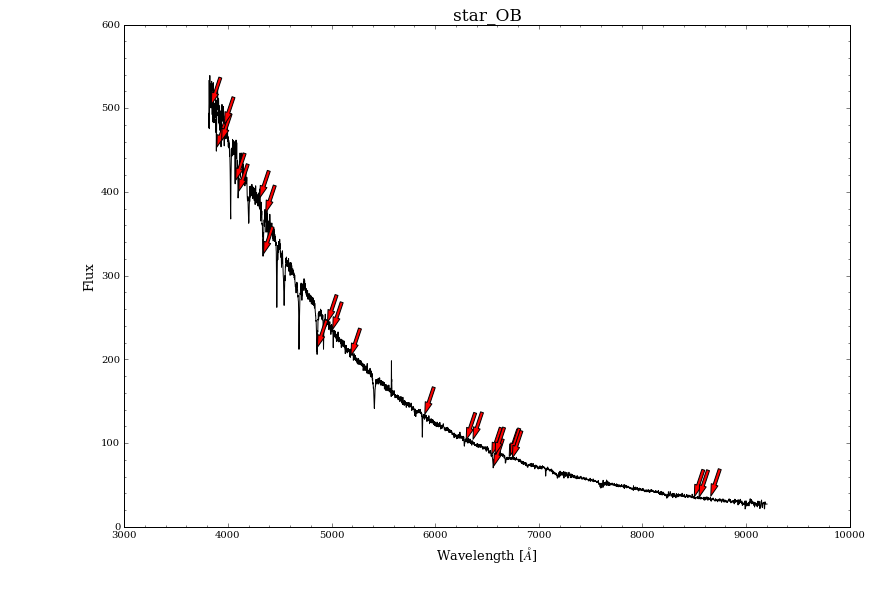

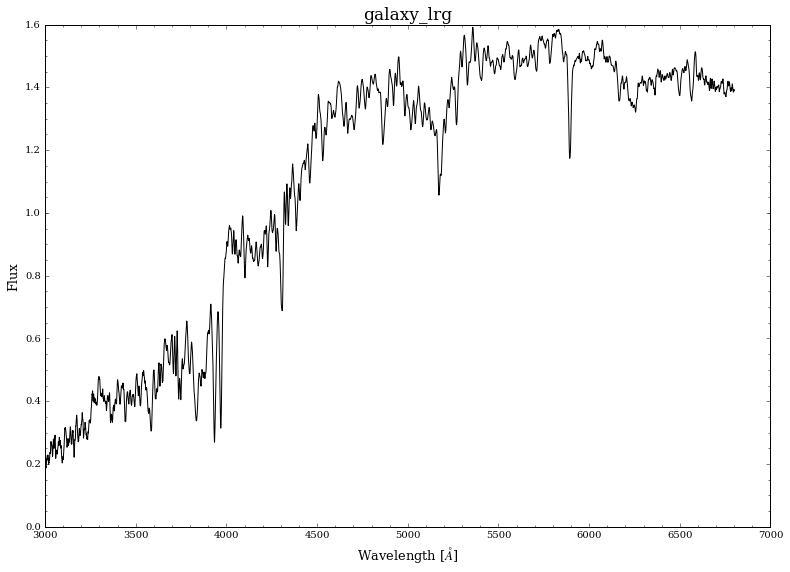

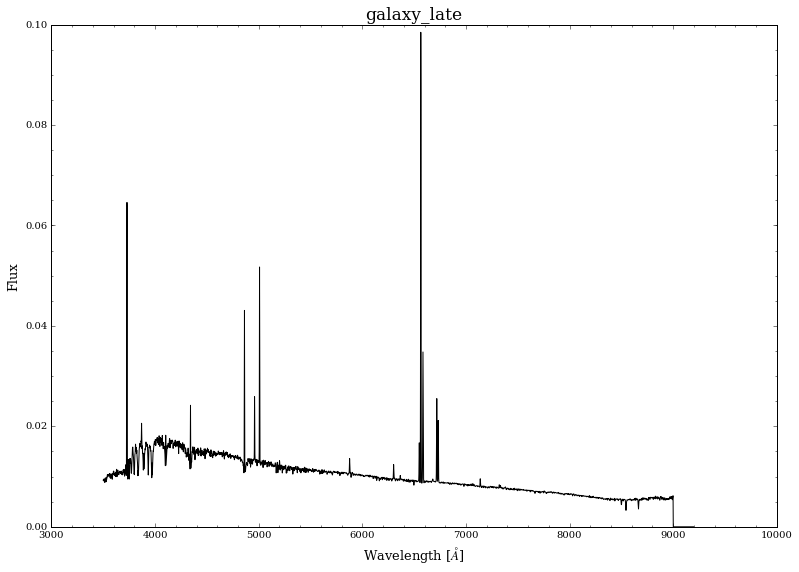

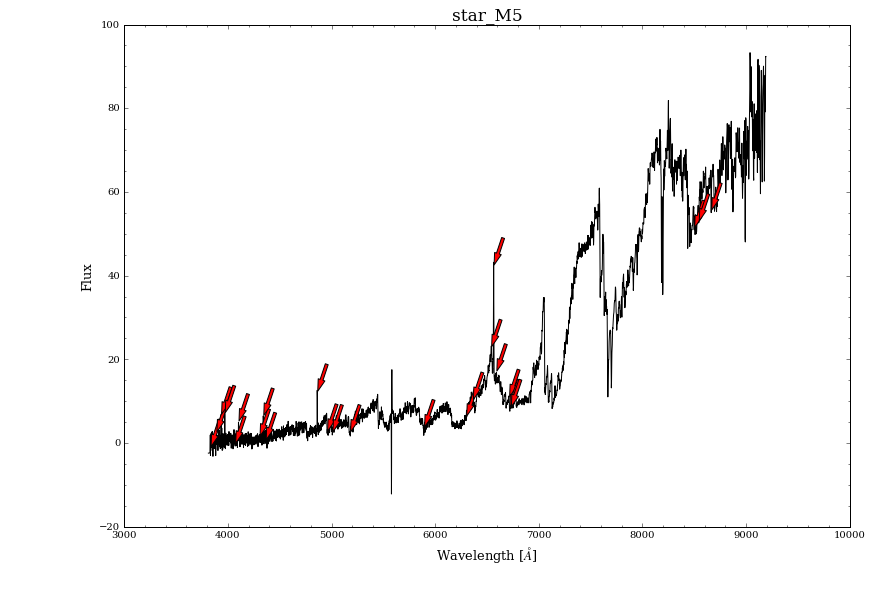

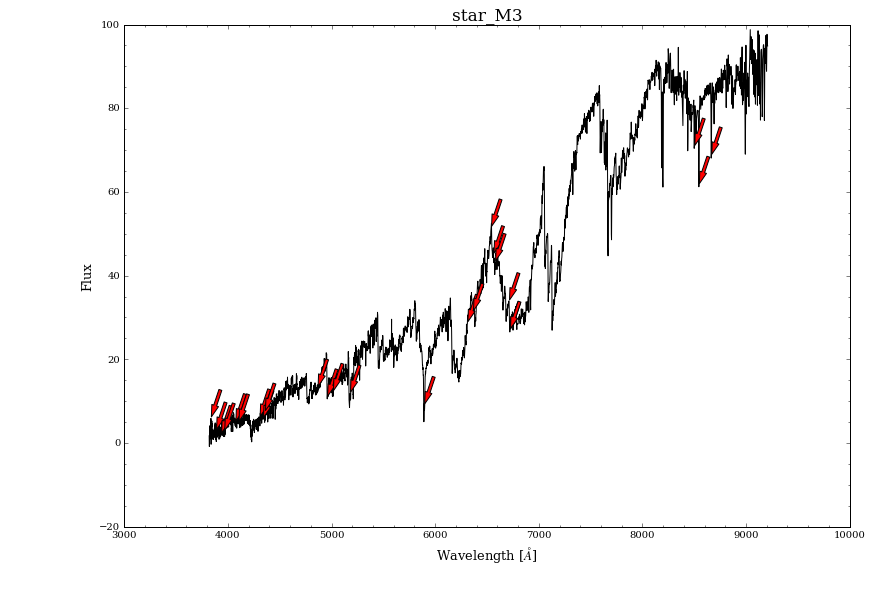

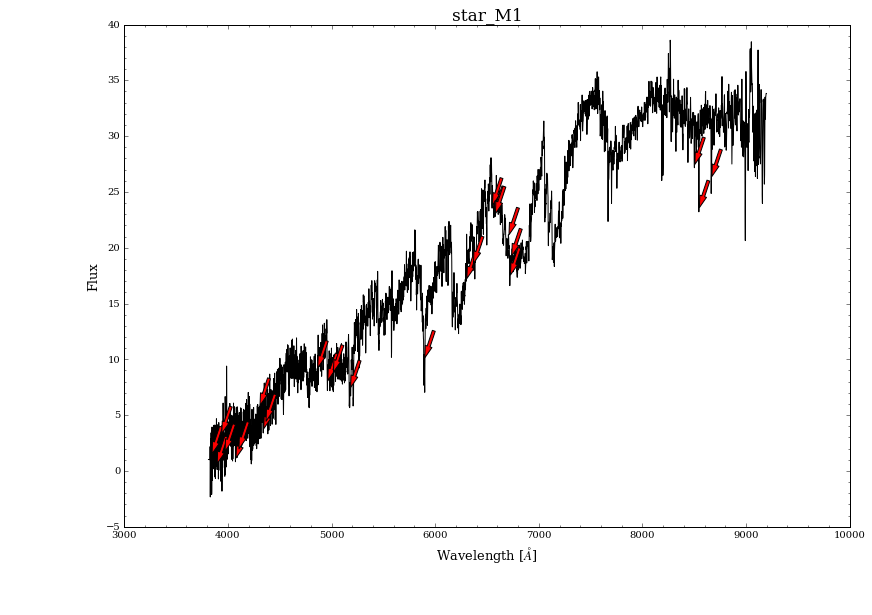

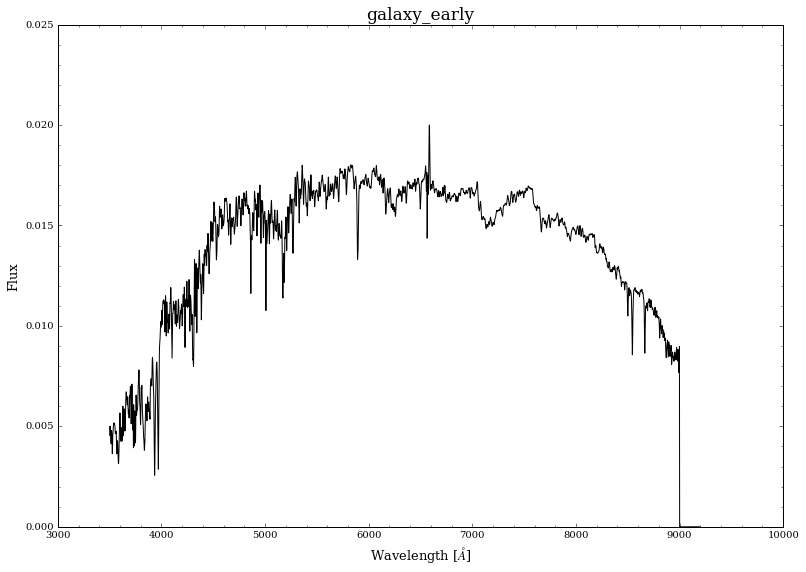

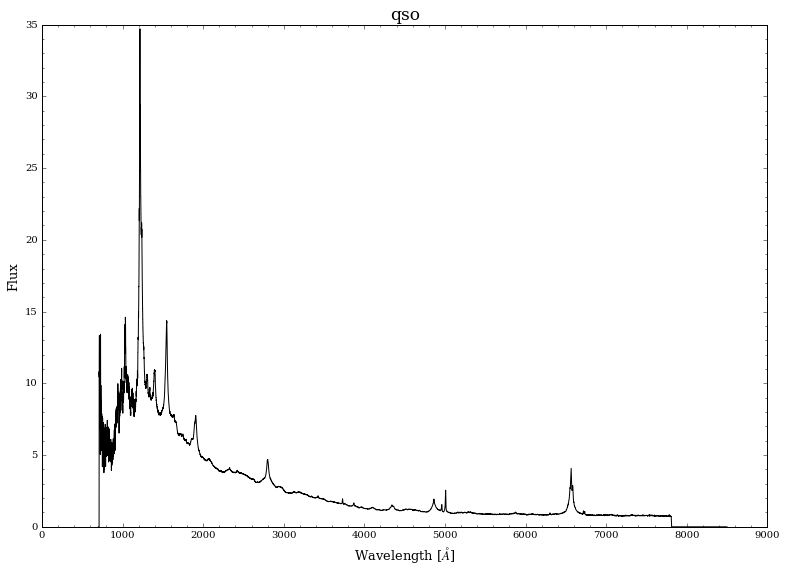

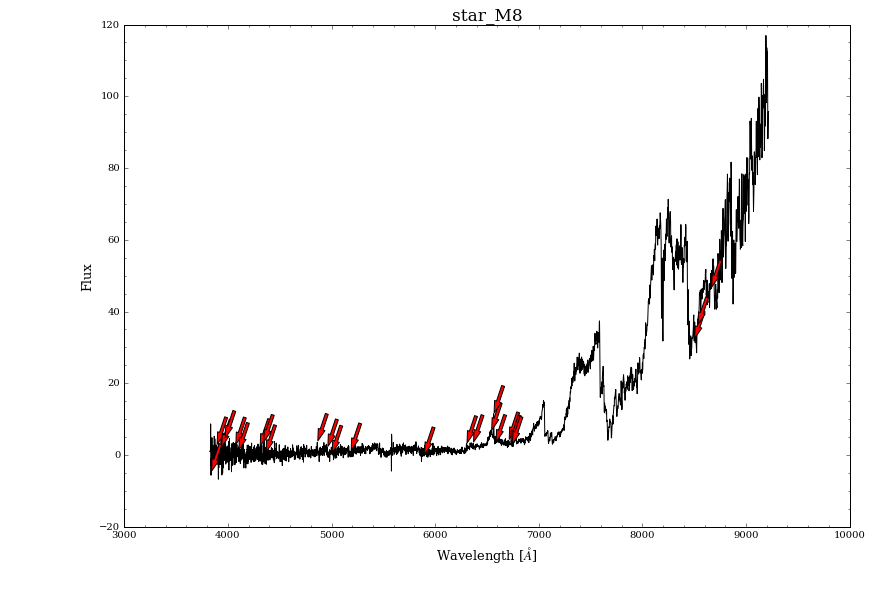

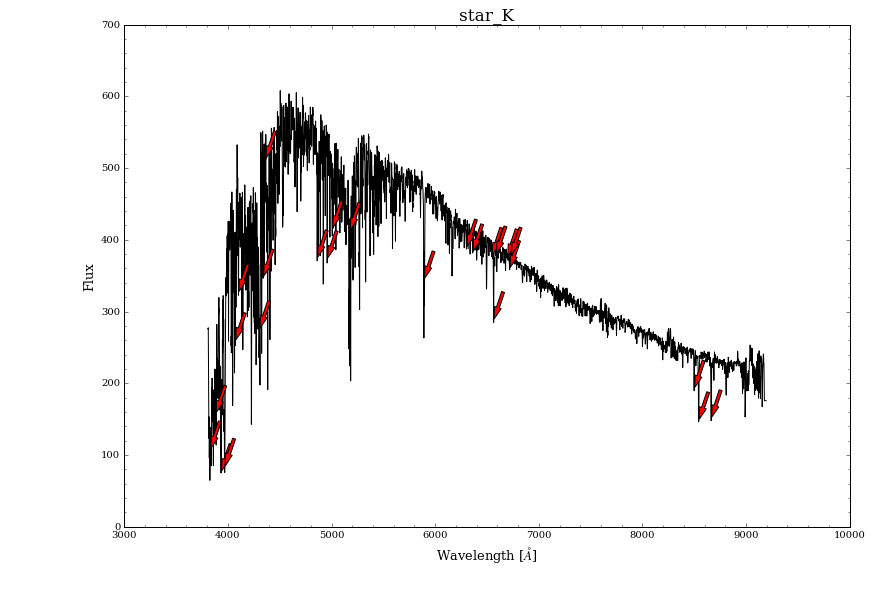

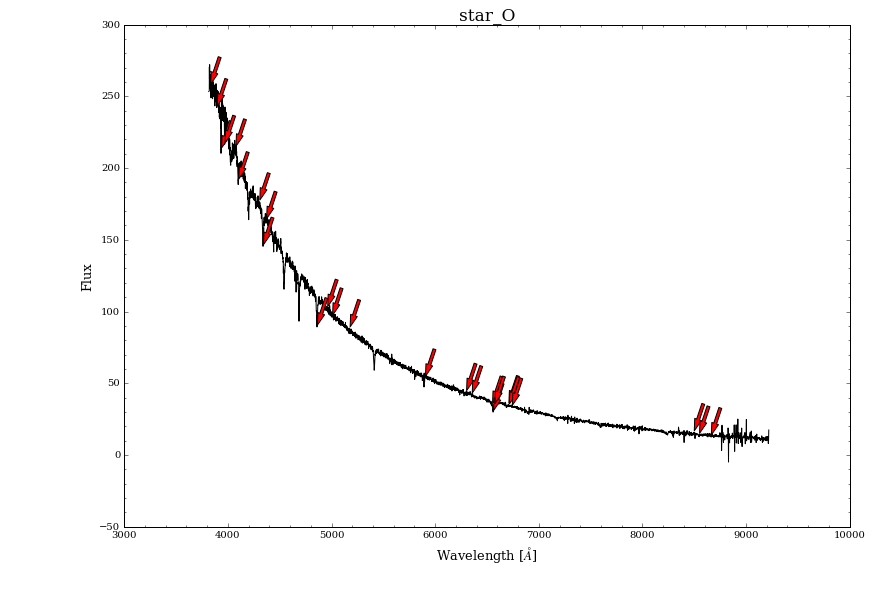

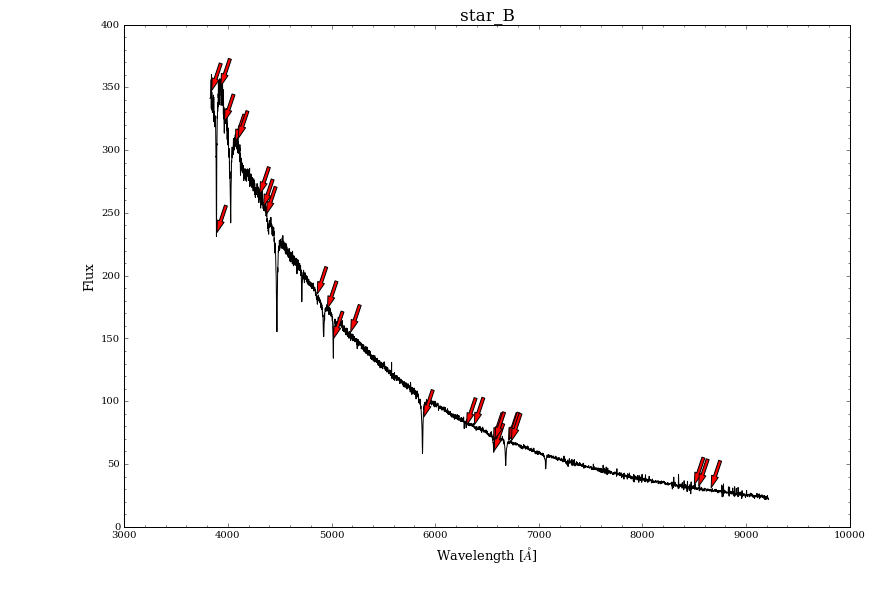

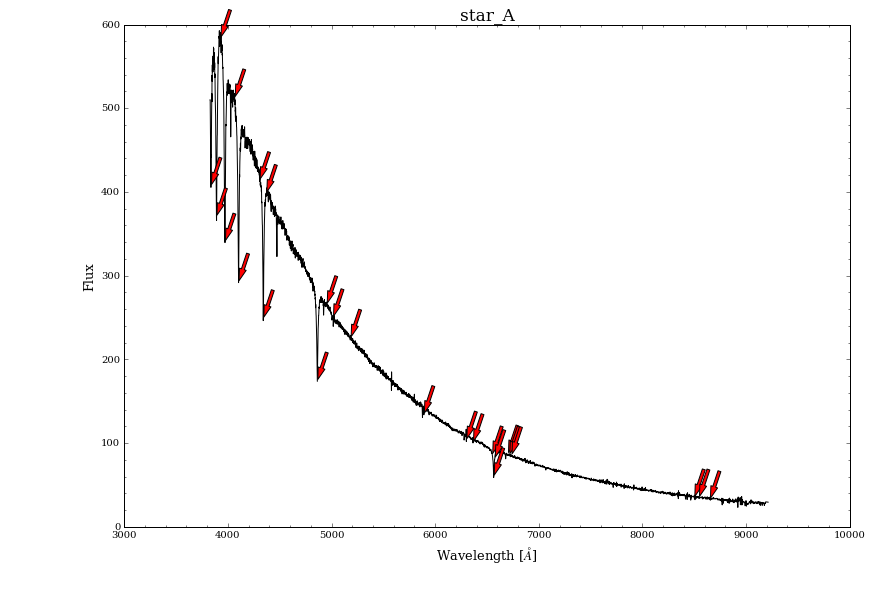

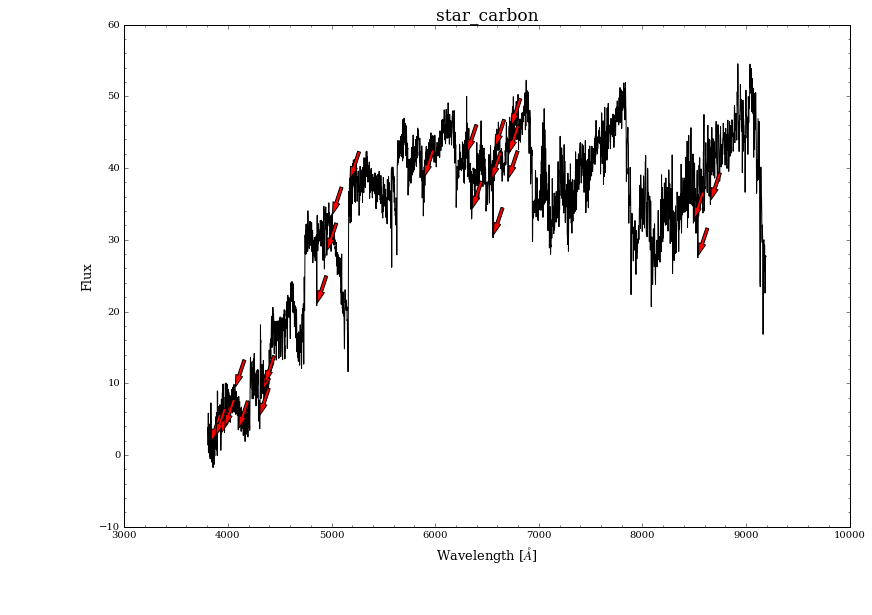

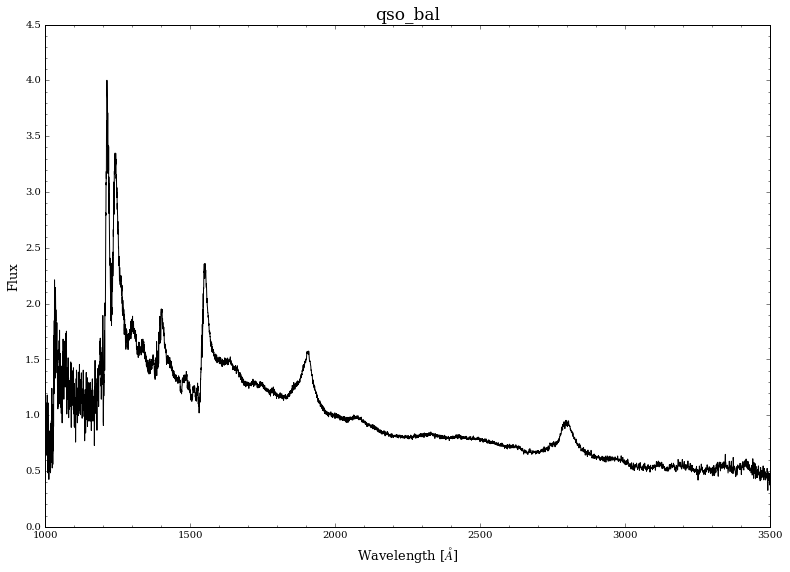

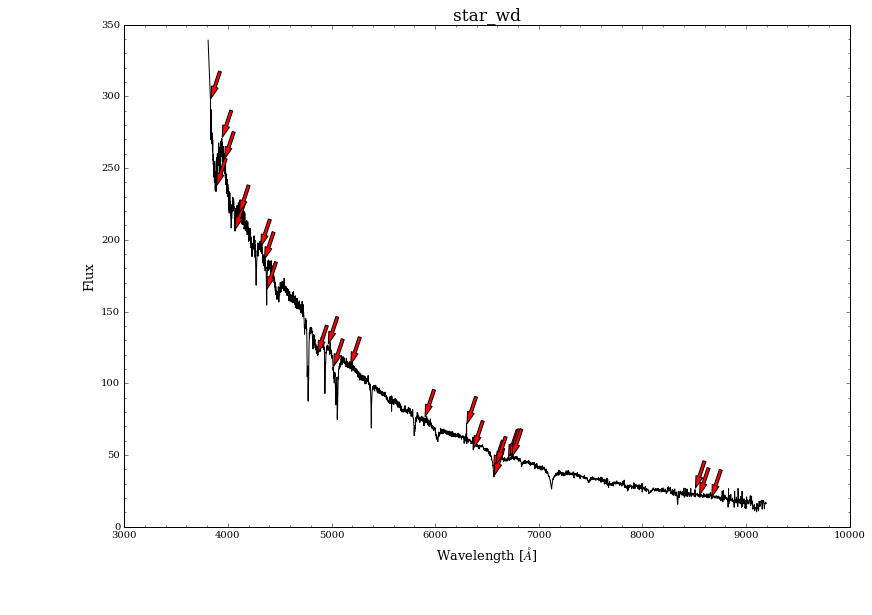

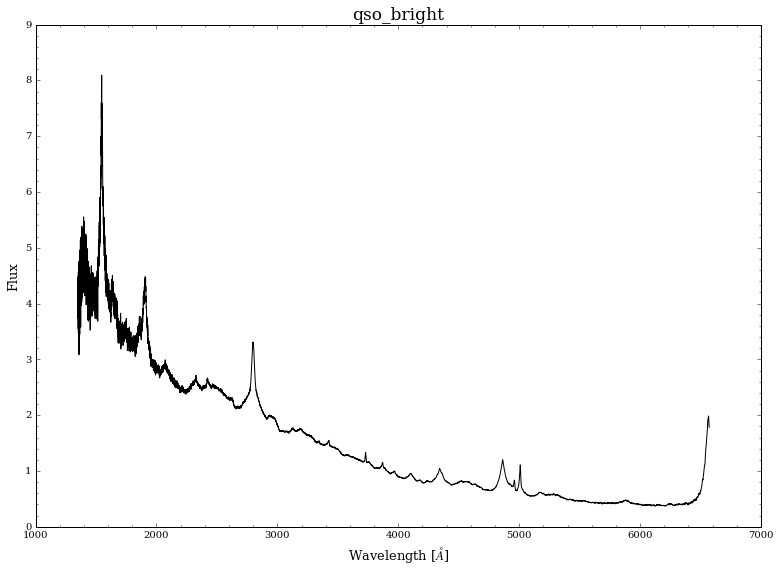

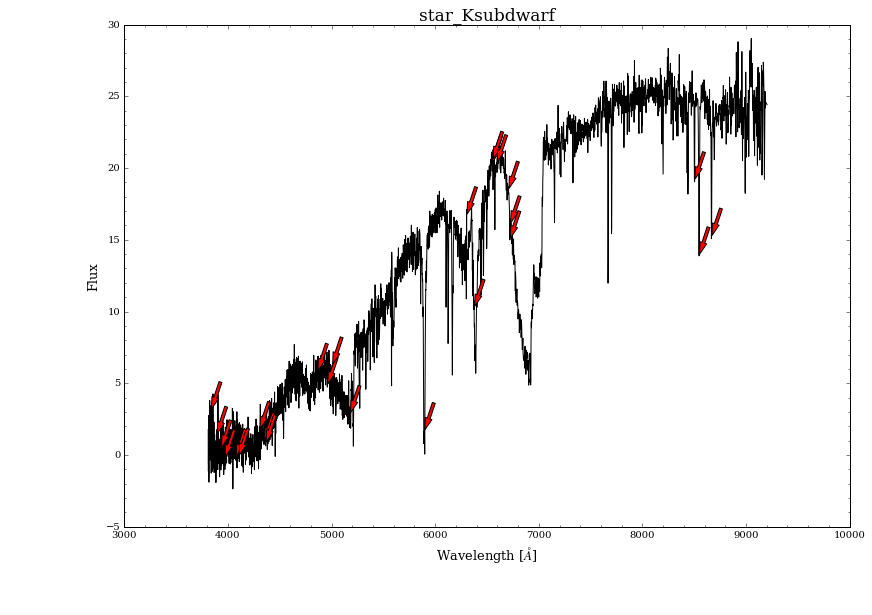

In [16]:
from astroquery.sdss import SDSS
from scipy import interpolate

rcParams['figure.max_open_warning'] = len(SDSS.AVAILABLE_TEMPLATES.keys())

obj_type = SDSS.AVAILABLE_TEMPLATES.keys()
for element in obj_type:
    result = SDSS.get_spectral_template(element)
    wave = result[0][2].data['wave    ']
    plot(result,element,wave)